In [183]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Prepare data </h1>

<h5> Load Excel file as dataframes </h5>

In [184]:
invoices = pd.read_excel('sales_original.xlsx', sheet_name = 'invoices')
assessment = pd.read_excel('sales_original.xlsx', sheet_name = 'assessment')
customers = pd.read_excel('sales_original.xlsx', sheet_name = 'customers')
products = pd.read_excel('sales_original.xlsx', sheet_name = 'products')
stock = pd.read_excel('sales_original.xlsx', sheet_name = 'stock')

KeyboardInterrupt: 

We cleaned the individual dataframes for our SQL queries. <br>
But for the EDA, we want to use all of the data. Sometimes the dropped duplicate rows or null values may still hold important information. <br>

The way these dataframes were created was: each row in each excel spread corresponds to the same row in all the other spreads. <br>
So we will concatenate along the row axis.


In [185]:
merged_table = pd.concat([invoices, assessment, customers, products, stock], axis = 1)

In [186]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,ASIN,CustomerID,Country,ASIN,title,product_type,StockCode,ASIN
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,B07GWKDLGT,18011,Germany,B07GWKDLGT,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,B07GWKDLGT
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,B01MTLH408,18011,Germany,B01MTLH408,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,B01MTLH408


In [187]:
merged_table.columns

Index(['InvoiceNo', 'ASIN', 'Quantity', 'price', 'total_sale', 'invoice_date',
       'invoice_time', 'CustomerID', 'rating', 'review_count', 'ASIN',
       'CustomerID', 'Country', 'ASIN', 'title', 'product_type', 'StockCode',
       'ASIN'],
      dtype='object')

Drop duplicate columns

In [188]:
merged_table.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True])

In [189]:
merged_table = merged_table.loc[:, ~merged_table.columns.duplicated()]

In [190]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,Country,title,product_type,StockCode
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001


Relabel columns 

In [191]:
merged_table = merged_table.rename(columns = {'InvoiceNo': 'invoice_no', 'ASIN':'product_id', 'Quantity': 'quantity', 'price': 'unit_price', 
                                'CustomerID': 'customer_id', 'Country': 'country', 'title':'product_name', 'StockCode': 'stock_code'})

Combine "invoice_date" + "invoice_time" as "invoice_datetime"

In [192]:
merged_table['invoice_datetime'] = merged_table['invoice_date'] + merged_table['invoice_time'].astype('timedelta64[h]')
merged_table = merged_table.drop(['invoice_date', 'invoice_time'], axis = 1)

In [193]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00


In [284]:
# Add "day_of_week" column
merged_table['day_of_week'] = merged_table['invoice_datetime'].dt.dayofweek # 0 = Monday, 1 = Tuesday, etc.

# Add "month" column
merged_table['month'] = merged_table['invoice_datetime'].dt.month

# Add "hour" column
merged_table['hour'] = merged_table['invoice_datetime'].dt.hour

# Add "year" column
merged_table['year'] = merged_table['invoice_datetime'].dt.year

# Add "quarter" column
merged_table['quarter'] = merged_table['invoice_datetime'].dt.quarter


In [285]:
merged_table.head()

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4
2,78536597,B0064FS7HI,1,12.99,12.99,18011,4.4,333,Germany,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",dslr camera,85034A,2018-12-01 17:00:00,5,12,17,2018,4
3,78536597,B013JHU5YG,1,199.99,199.99,18011,4.3,86,Germany,Lowepro Whistler BP 350 AW (Grey) . Profession...,dslr camera,72798C,2018-12-01 17:00:00,5,12,17,2018,4
4,78536597,B06XWN9Q99,1,7.49,7.49,18011,4.7,15717,Germany,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,dslr camera,20726,2018-12-01 17:00:00,5,12,17,2018,4


Save the dataframe as csv

In [254]:
merged_table.to_csv('merged_table', index = False)

<h3> EDA </h3>

The dataframe contains data from Dec 2018 until Dec 2019. <br>
Since we will be studying monthly and quarterly trends too, we need to be studying complete years. <br>
So, for the following analysis, we will work only with the 2019 data.

In [255]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4


<h3> Customer buying pattern </h3>

Number of unique purchases vs day_of_week, month, hour of day

In [290]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4


In [301]:
# Get unique invoice numbers and invoice datetime.
# Only select the year 2019

unique_invoices = merged_table[merged_table['year'] == 2019].groupby(['invoice_no', 'day_of_week', 'month','hour', 'quarter']).count().reset_index().iloc[:,:5]

In [302]:
unique_invoices.head()

,invoice_no,day_of_week,month,hour,quarter
0,78539993,4,1,10,1
1,78540001,4,1,10,1
2,78540002,4,1,10,1
3,78540003,4,1,10,1
4,78540004,4,1,10,1


In [303]:
unique_invoices_dow = unique_invoices.groupby(['day_of_week'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('day_of_week')
unique_invoices_month = unique_invoices.groupby(['month'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('month')
unique_invoices_hour = unique_invoices.groupby(['hour'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('hour')
unique_invoices_quarter = unique_invoices.groupby(['quarter'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('quarter')

Strangely, there appear to have been no orders on Tuesday (day_of_week = 1). <br>
Add that missing column 

In [304]:
unique_invoices_dow = unique_invoices_dow.reset_index()
unique_invoices_dow

,day_of_week,num_orders
0,0,3047
1,2,2052
2,3,2993
3,4,3430
4,5,3477
5,6,3964


In [305]:
new_row = pd.DataFrame({'day_of_week': [1],  'num_orders':[0]})
unique_invoices_dow = pd.concat([unique_invoices_dow, new_row], axis = 0).sort_values(['day_of_week'])

In [306]:
unique_invoices_dow.index = [0,1,2,3,4,5,6]

In [307]:
unique_invoices_dow

,day_of_week,num_orders
0,0,3047
1,1,0
2,2,2052
3,3,2993
4,4,3430
5,5,3477
6,6,3964


In [308]:
unique_invoices_month.reset_index (inplace=True)

In [309]:
unique_invoices_month

,month,num_orders
0,1,1100
1,2,1108
2,3,1496
3,4,1277
4,5,1707
5,6,1588
6,7,1497
7,8,1362
8,9,1884
9,10,2154


In [310]:
unique_invoices_hour = unique_invoices_hour.sort_index().reset_index()
unique_invoices_hour

,hour,num_orders
0,6,1
1,7,27
2,8,540
3,9,1403
4,10,2238
5,11,2294
6,12,3061
7,13,2591
8,14,2339
9,15,2173


In [311]:
unique_invoices_quarter = unique_invoices_quarter.reset_index()

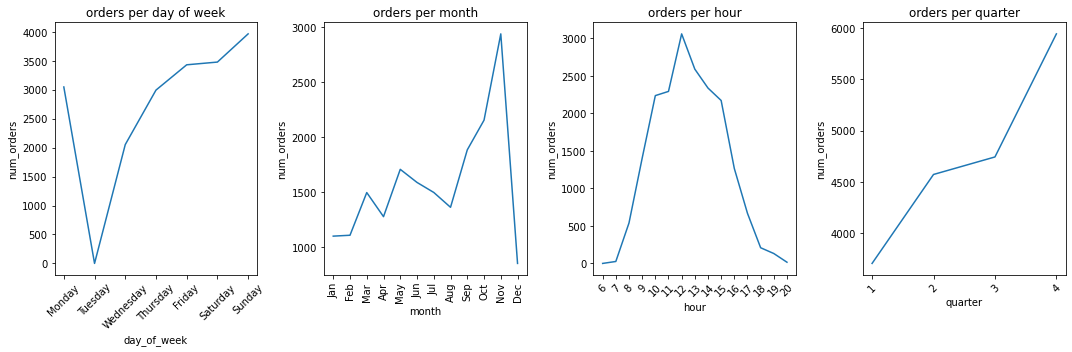

In [318]:
fig, ax = plt.subplots(1,4, figsize = (15,5))
ax_0 = sns.lineplot(ax = ax[0], data = unique_invoices_dow, x = 'day_of_week', y = 'num_orders')
ax_0.set_xticks(range(len(unique_invoices_dow['day_of_week'])))
ax_0.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'], rotation = 45)
ax_0.set_title('orders per day of week')
ax_1 = sns.lineplot(ax = ax[1], data = unique_invoices_month, x = 'month', y = 'num_orders')
ax_1.set_xticks(range(1, len(unique_invoices_month.index)+1))
ax_1.set_xticklabels(['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation = 90)
ax_1.set_title('orders per month')
ax_2 = sns.lineplot(ax = ax[2], data = unique_invoices_hour, x = 'hour', y = 'num_orders')
ax_2.set_xticks(range(6, len(unique_invoices_hour.index)+6))
ax_2.set_xticklabels(range(6, len(unique_invoices_hour.index)+6), rotation = 45)
ax_2.set_title('orders per hour')
ax_3 = sns.lineplot(ax = ax[3], data = unique_invoices_quarter, x = 'quarter', y = 'num_orders')
ax_3.set_xticks(range(1, len(unique_invoices_quarter['quarter'])+1))
ax_3.set_xticklabels(range(1, len(unique_invoices_quarter['quarter'])+1), rotation = 45)
ax_3.set_title('orders per quarter')


plt.tight_layout()
plt.show()

Note that in the graph for "orders per month", the num_orders drops suddenly in December. <br>
This is only because the data only goes up to 9 Dec. 

<h3> Group by date </h3>

In [319]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4


In [320]:
merged_table['invoice_date'] = merged_table['invoice_datetime'].dt.date

In [321]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


<h3> For each date: <br>
- sum of unique invoice numbers (i.e. number of orders) <br>
- sum of total_sale </h3>

In [339]:
# number of unique invoice numbers per date
# Only look at year 2019
num_orders_df = pd.DataFrame(merged_table[merged_table['year']==2019].groupby('invoice_date')['invoice_no'].nunique()).reset_index().rename(columns = {'invoice_no':'num_invoices'})
num_orders_df.head(2)

,invoice_date,num_invoices
0,2019-01-04,39
1,2019-01-05,55


In [340]:
# total sale per date
total_sale_df = pd.DataFrame(merged_table[merged_table['year']==2019].groupby('invoice_date')['total_sale'].sum()).reset_index()
total_sale_df.head(2)

,invoice_date,total_sale
0,2019-01-04,1002201.60
1,2019-01-05,1786655.03


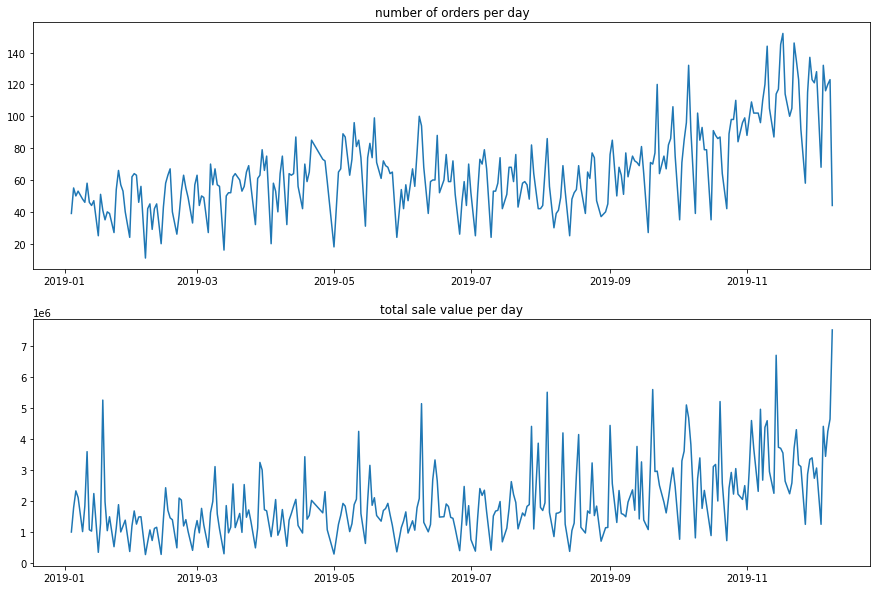

In [357]:
fig, ax = plt.subplots(2,1,figsize = (15,10))
ax[0].plot(num_orders_df['invoice_date'], num_orders_df['num_invoices'])
ax[0].set_title('number of orders per day')
ax[1].plot(total_sale_df['invoice_date'], total_sale_df['total_sale'])
ax[1].set_title('total sale value per day')
plt.show()

Look at days with top 10 number of orders and total_sale

In [358]:
top_20_order_days = num_orders_df.sort_values(by='num_invoices', ascending = False).head(20)['invoice_date'].tolist()
top_20_order_days = [x.strftime(('%Y/%m/%d')) for x in top_20_order_days]
top_20_revenue_days = total_sale_df.sort_values(by='total_sale', ascending = False).head(20)['invoice_date'].tolist()
top_20_revenue_days = [x.strftime(('%Y/%m/%d')) for x in top_20_revenue_days]
top_20_order_days
top_20_revenue_days

['2019/12/09',
 '2019/11/14',
 '2019/09/20',
 '2019/08/04',
 '2019/01/18',
 '2019/10/20',
 '2019/06/09',
 '2019/10/05',
 '2019/11/07',
 '2019/10/06',
 '2019/12/08',
 '2019/11/03',
 '2019/11/10',
 '2019/09/01',
 '2019/12/05',
 '2019/07/28',
 '2019/11/09',
 '2019/11/23',
 '2019/05/12',
 '2019/12/07']

In [368]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


In [369]:
top_countries = merged_table.groupby('country').agg({'invoice_no':'nunique', 'customer_id': 'nunique', 'total_sale':'sum', 'quantity':'sum'}).rename(
                            columns = {'invoice_no': 'num_orders', 'customer_id': 'num_customers', 'quantity':'total_units'}).sort_values(by = ['num_orders', 'total_sale'], ascending = False).reset_index()

In [370]:
top_countries['rev_per_customer'] = top_countries['total_sale'] / top_countries['num_customers']

In [371]:
top_countries

,country,num_orders,num_customers,total_sale,total_units,rev_per_customer
0,Germany,18628,3922,5.177474e+08,5062416,1.320111e+05
1,United Kingdom,475,103,1.238764e+07,133520,1.202683e+05
2,France,387,88,1.155420e+07,116332,1.312977e+05
3,Ireland,288,4,1.588787e+07,153773,3.971968e+06
4,Belgium,98,25,2.474314e+06,23672,9.897256e+04
5,Netherlands,94,9,2.200264e+07,209202,2.444738e+06
6,Spain,88,30,2.754244e+06,30061,9.180814e+04
7,Australia,56,9,9.848729e+06,87033,1.094303e+06
8,Portugal,56,20,1.714644e+06,17250,8.573220e+04
9,Switzerland,50,22,2.782129e+06,31893,1.264604e+05
